## Match genes to proteins

In [ ]:
from pyensembl import EnsemblRelease

genome = EnsemblRelease(77)
# genome.download()
# genome.index()

In [ ]:
label = 'ENSG00000002079'

In [ ]:
genome.gene_ids()[0]

In [ ]:
gene = genome.gene_by_id('ENSG00000000003')

# Observed and predicted gene expression values were obtained by summing up the observed/predicted CAGE read counts
# at all unique TSS locations of the gene. For each TSS location, we used the 128-bp bin overlapping the TSS as well
# as the two neighboring bins (3 bins in total).

# For each gene, look through all transcipts - protein coding / not, and record offsets from gene start
gene.transcripts

In [ ]:
len(genome.protein_ids())

In [ ]:
protein_id = genome.protein_ids()[0]
genome.protein_sequence(protein_id)

# results = []
# for protein_id in genome.protein_ids():
#     sequence = genome.protein_sequence(protein_id)
#     if '*' not in sequence:
#         results.append({
#             'protein_id': protein_id,
#             'protein_sequence': sequence
#         })

In [ ]:
gene.transcripts[0]

In [ ]:
gene

In [ ]:
# !pip install pybiomart

In [ ]:
from pybiomart import Dataset as PyBiomartDataset

dataset = PyBiomartDataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')

In [ ]:
# dataset.list_attributes().to_clipboard()

In [ ]:
genes_proteins = dataset.query(attributes=['ensembl_gene_id', 'ensembl_peptide_id',
                                            'gene_biotype', 'transcript_is_canonical', 'peptide'], filters={})
genes_proteins = genes_proteins[genes_proteins['Ensembl Canonical'] == 1.0]

In [ ]:
# genes_proteins.to_csv('gene2protein.csv')

In [ ]:
import anndata as ad

ADATA_PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type.h5ad'
adata = ad.read_h5ad(ADATA_PATH)

In [ ]:
genes = list(adata.var.index)

In [ ]:
genes

In [ ]:
proteins = []
for gene in genes:
    prot = genes_proteins[genes_proteins['Gene stable ID'] == gene]
    if len(prot) != 1:
        raise ValueError(f'Gene {gene} has {len(prot)} proteins')
    proteins.append(prot)

In [ ]:
import pandas as pd

df = pd.concat(proteins)
df = df.set_index('Gene stable ID')
df = df[['Peptide', 'Protein stable ID']]


In [ ]:
df

In [ ]:
df['Peptide Length'] = df['Peptide'].apply(len)

In [ ]:
(df['Peptide Length'] < 100).sum()

In [ ]:
df.to_csv('gene2protein_coding.csv')

## Generate protein embeddins

In [ ]:
!pip install fair-esm

In [ ]:
import pandas as pd

df = pd.read_csv('gene2protein_coding.csv', index_col='Gene stable ID')

In [ ]:
import esm


# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()  # disables dropout for deterministic results

In [ ]:
from torch.utils.data import DataLoader

TRUNCATION_SEQ_LENGTH = 1024
TOKENS_PER_BATCH = 2048

sequences = df['Peptide'].apply(lambda x: x.replace('*', '')).values
genes = df.index.values
dataset = esm.data.FastaBatchedDataset(genes, sequences)
batches = dataset.get_batch_indices(TOKENS_PER_BATCH, extra_toks_per_seq=1)
data_loader = DataLoader(
    dataset, collate_fn=alphabet.get_batch_converter(TRUNCATION_SEQ_LENGTH), batch_sampler=batches
)

In [ ]:
from tqdm import tqdm
import zarr

In [ ]:
NUM_GENES = len(dataset)
EMBED_DIM = 1280
EMBEDDING_LAYER = 33

In [ ]:
BASE_PT = "/home/ec2-user/esm"
PROTEIN_EMBED_PATH = BASE_PT + "/ESM_proteins_embeddings_var_0.zarr"

In [ ]:
z_embedding_prot = zarr.open(
    PROTEIN_EMBED_PATH,
    mode="w",
    # shape=(5 + 2*len(sigmas), NUM_GENES, EMBED_DIM),
    shape=(NUM_GENES, 2, EMBED_DIM),
    chunks=(1, 2, EMBED_DIM),
    dtype="float32",
)

In [ ]:
import torch


if torch.cuda.is_available():
    model = model.to(device="cuda", non_blocking=True)

In [ ]:
for batch_idx, (labels, strs, toks) in tqdm(enumerate(data_loader)):
    if torch.cuda.is_available():
        toks = toks.to(device="cuda", non_blocking=True)

    out = model(toks, repr_layers=[EMBEDDING_LAYER], return_contacts=False)
    representations = out["representations"][EMBEDDING_LAYER]
    
    # Save data for each protein
    for i, label in enumerate(labels):
        index = df.index.get_loc(label)
        truncate_len = min(TRUNCATION_SEQ_LENGTH, len(strs[i]))
        bos = representations[i, 0]
        mean = representations[i, 1:truncate_len + 1].mean(dim=0)
        z_embedding_prot[i, 0, :] = bos.detach().cpu().numpy()
        z_embedding_prot[i, 1, :] = mean.detach().cpu().numpy()


## Add embeddings

In [1]:
import zarr

z = zarr.open('/home/ec2-user/esm/ESM_proteins_embeddings_var_0.zarr', 'r')


In [2]:
import anndata as ad

PATH = '/home/ec2-user/cell_census/tabula_sapiens__gene_prot__sample_donor_id__label_cell_type.h5ad'

adata = ad.read_h5ad(PATH)

In [3]:
# for key in list(adata.varm.keys())[1:]:
#     del adata.varm[key]

In [4]:
import numpy as np

In [5]:
z.shape

(19431, 2, 1280)

In [6]:
adata.varm['embedding_prot_bos'] = np.asarray(z[:, 0, :])
adata.varm['embedding_prot_mean'] = np.asarray(z[:, 1, :])

In [7]:
PATH_NEW = '/home/ec2-user/cell_census/tabula_sapiens__gene_prot__sample_donor_id__label_cell_type.h5ad'

adata.write_h5ad(PATH_NEW)

In [8]:
import matplotlib.pyplot as plt

(0.0, 200.0)

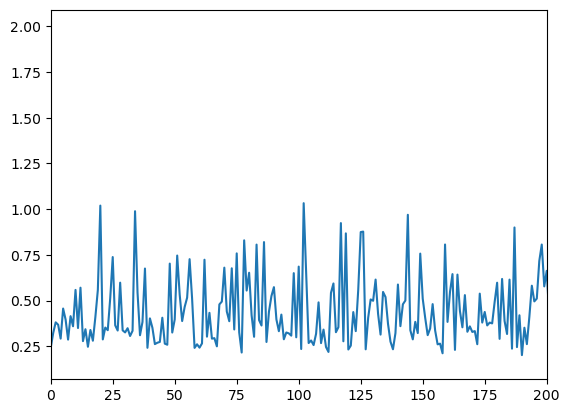

In [9]:
plt.plot(z[:, 1, :].max(axis=1));
plt.xlim([0, 200])